## MODEL INPUTS ##

In [1]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


## Metrology Downloaders

In [2]:
# inputs
import math
import pandas as pd
from tqdm import tqdm
import time
import folium
import numpy as np
from time import sleep
import metpy.calc
radius = 1000.0 # m - the following code is an approximation that stays reasonably accurate for distances < 100km
centerLat =  37.429019 #latitude of circle center, decimal degrees
centerLon = 140.527985# Longitude of circle center, decimal degrees
# parameters
N = 3 # number of discrete sample points to be generated along the circle
scale = 100
# generate points
lat, lon = centerLat, centerLon #center coordinate
dist, coors = 200, 2 #meters, num coordinates in each direction

#Creating the offset grid
mini, maxi = -dist*coors, dist*coors
n_coord = coors*2+1
axis = np.linspace(mini, maxi, n_coord)
X, Y = np.meshgrid(axis, axis)


#avation formulate for offsetting the latlong by offset matrices
R = 6378137 #earth's radius
dLat = X/R
dLon = Y/(R*np.cos(np.pi*lat/180))
latO = lat + dLat * 180/np.pi
lonO = lon + dLon * 180/np.pi

#stack x and y latlongs and get (lat,long) format
output = np.stack([latO, lonO]).transpose(1,2,0)

circlePoints = []
for i in output:
    for x in i:
        circlePoints.append({'lat':x[0],'lon':x[-1]})

# Initial date of interest (inclusive).
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('NOAA/NWS/RTMA')

# Import the USGS ground elevation image.
WIND = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')

# Initial date of interest (inclusive).
i_date = '2011-03-13T12:00:00'

# Final date of interest (exclusive).
f_date = '2011-03-13T15:00:00'
# Selection of appropriate bands and dates for LST.


# Initial date of interest (inclusive).
# Define the urban location of interest as a point near Lyon, France.
nodes = []
for i in circlePoints:
    u_lon = i['lon']
    u_lat = i['lat']
    nodes.append([u_lon,u_lat])
print(nodes)

# make points from nodes
points = [ee.Geometry.Point(coord) for coord in nodes]

# make features from points (name by list order)
feats = [ee.Feature(p, {'name': 'node{}'.format(i)}) for i, p in enumerate(points)]
# make a featurecollection from points
extracted = []
for p in tqdm(points, ncols = 100, desc = 'Loading Weather Data'):
    landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('u_component_of_wind_10m','v_component_of_wind_10m') \
        .filterBounds(p) \
        .filterDate(i_date, f_date)\
        .median()
    extracted.append(landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())
print('Calculating Model Inputs...')

p1 = ee.Geometry.Point(nodes[0])
solar = []
#Get net solar radiation for Pasquill-Gifford Stability Class

landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('surface_solar_radiation_downwards') \
    .filterBounds(p1) \
    .filterDate(i_date, f_date)\
    .median()
solar.append(landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())

temp= []
#Get Humidity for Model input
landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('temperature_2m') \
    .filterBounds(p1) \
    .filterDate(i_date, f_date)\
    .median()
temp.append((landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())['temperature_2m']-273.15)

dp= []
#Get Humidity for Model input
landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('dewpoint_temperature_2m') \
    .filterBounds(p1) \
    .filterDate(i_date, f_date)\
    .median()
dp.append((landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())['dewpoint_temperature_2m']-273.15)
T = temp[0]
TD = dp[0]
solar = solar[0]['surface_solar_radiation_downwards']/(10800*8) # Converts J/m2 to W/m2, divides by seconds in 3hrs
RH = 100*(math.exp((17.625*TD)/(243.04+TD))/math.exp((17.625*T)/(243.04+T))) #Formula for Rel. Humidity from Dewpoint and Tempreature
print('Done.', solar)
print('Plotting Visualizer')

# Python code demonstrate creating
# DataFrame from dict narray / lists
# By default addresses.
geedata = {'lat':[],'lon':[],'u_wind':[],'v_wind':[]} 
for i in range(len(nodes)):
    geedata['lat'].append(nodes[i][0])
    geedata['lon'].append(nodes[i][-1])
    geedata['u_wind'].append(extracted[i]['u_component_of_wind_10m']*4)
    geedata['v_wind'].append(extracted[i]['v_component_of_wind_10m']*4)

df = pd.DataFrame(geedata).set_index(['lat', 'lon'])
geedataxr = df.to_xarray()
 


Loading Weather Data:   0%|                                                  | 0/25 [00:00<?, ?it/s]

[[140.52346009138708, 37.42542573886352], [140.52346009138708, 37.42722236943176], [140.52346009138708, 37.429019], [140.52346009138708, 37.43081563056823], [140.52346009138708, 37.43261226113648], [140.52572254569355, 37.42542573886352], [140.52572254569355, 37.42722236943176], [140.52572254569355, 37.429019], [140.52572254569355, 37.43081563056823], [140.52572254569355, 37.43261226113648], [140.527985, 37.42542573886352], [140.527985, 37.42722236943176], [140.527985, 37.429019], [140.527985, 37.43081563056823], [140.527985, 37.43261226113648], [140.53024745430645, 37.42542573886352], [140.53024745430645, 37.42722236943176], [140.53024745430645, 37.429019], [140.53024745430645, 37.43081563056823], [140.53024745430645, 37.43261226113648], [140.53250990861292, 37.42542573886352], [140.53250990861292, 37.42722236943176], [140.53250990861292, 37.429019], [140.53250990861292, 37.43081563056823], [140.53250990861292, 37.43261226113648]]


Loading Weather Data: 100%|█████████████████████████████████████████| 25/25 [00:04<00:00,  5.04it/s]


Calculating Model Inputs...
Done. 205.10847222222222
Plotting Visualizer


In [13]:
#Load Data from Model Outputs
import numpy as np
import sys
from scipy.special import erfcinv as erfcinv
from scipy.interpolate import interp2d
import scipy as sp
import tqdm as tqdm
import time
C4 = np.loadtxt("modeloutput.txt").reshape(1601, 1601)
x = np.loadtxt("x.txt").reshape(1601, 1601)
y = np.loadtxt("y.txt").reshape(1601, 1601)

            
mapped = []
s1,s2 = C4.shape[0],C4.shape[-1] #finds array shape
for i in tqdm.tqdm(range(s2),ncols = 100,desc = 'Generating reference'):
    for z in range(s2):
        #print(x[i][z],y[i][z])
        mapped.append(C4[i][z]) #makes reference map


for i in range(1):
    radius = 1000.0 # m - the following code is an approximation that stays reasonably accurate for distances < 100km
    centerLat = 37.429019# latitude of circle center, decimal degrees
    centerLon = 140.527985  # Longitude of circle center, decimal 
    # parameters
    N = 10 # number of discrete sample points to be generated along the circle
    scale = 100
    # generate points
    lat, lon = centerLat, centerLon #center coordinate
    dist, coors = 2000, 20 #meters, num coordinates in each direction

    #Creating the offset grid
    mini, maxi = -dist*coors, dist*coors
    n_coord = coors*2+1
    axis = np.linspace(mini, maxi, n_coord)
    X, Y = np.meshgrid(axis, axis)


    #avation formulate for offsetting the latlong by offset matrices
    R = 6378137 #earth's radius
    dLat = X/R
    dLon = Y/(R*np.cos(np.pi*lat/180))
    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi
    output = np.stack([latO, lonO]).transpose(1,2,0)
    circlePoints = []
    for i in output:
        for x in i:
            circlePoints.append({'lat':x[0],'long':x[-1]})


Generating reference: 100%|███████████████████████████████████| 1601/1601 [00:00<00:00, 2575.63it/s]


In [3]:
import math
import pandas as pd
from tqdm import tqdm
import time
import folium
import numpy as np
from time import sleep
import metpy.calc
solaris = []
def metrodownloader(day,time,dayf,timef):
    radius = 1000.0 # m - the following code is an approximation that stays reasonably accurate for distances < 100km
    centerLat =  37.4215 #latitude of circle center, decimal degrees
    centerLon = 141.0314# Longitude of circle center, decimal degrees
    # parameters
    N = 3 # number of discrete sample points to be generated along the circle
    scale = 100
    # generate points
    lat, lon = centerLat, centerLon #center coordinate
    dist, coors = 2000, 20 #meters, num coordinates in each direction

    #Creating the offset grid
    mini, maxi = -dist*coors, dist*coors
    n_coord = coors*2+1
    axis = np.linspace(mini, maxi, n_coord)
    X, Y = np.meshgrid(axis, axis)


    #avation formulate for offsetting the latlong by offset matrices
    R = 6378137 #earth's radius
    dLat = X/R
    dLon = Y/(R*np.cos(np.pi*lat/180))
    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi

    #stack x and y latlongs and get (lat,long) format
    output = np.stack([latO, lonO]).transpose(1,2,0)

    circlePoints = []
    for i in output:
        for x in i:
            circlePoints.append({'lat':x[0],'lon':x[-1]})

    # Initial date of interest (inclusive).
    lc = ee.ImageCollection('MODIS/006/MCD12Q1')

    # Import the MODIS land surface temperature collection.
    lst = ee.ImageCollection('NOAA/NWS/RTMA')

    # Import the USGS ground elevation image.
    WIND = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
    
    iput = f'2011-03-{day}T{time}'
    fput = f'2011-03-{dayf}T{timef}'
    
    

    # Initial date of interest (inclusive).
    i_date = iput

    # Final date of interest (exclusive).
    f_date = fput
    # Selection of appropriate bands and dates for LST.
    print(f'Downloading metrology from date', iput, 'to', fput,'.')

    # Initial date of interest (inclusive).
    # Define the urban location of interest as a point near Lyon, France.
    nodes = []
    for i in circlePoints:
        u_lon = i['lon']
        u_lat = i['lat']
        nodes.append([u_lon,u_lat])

    # make points from nodes
    points = [ee.Geometry.Point(coord) for coord in nodes]

    # make features from points (name by list order)
    feats = [ee.Feature(p, {'name': 'node{}'.format(i)}) for i, p in enumerate(points)]
    # make a featurecollection from points
    extracted = []
    for p in tqdm(points, ncols = 100, desc = 'Loading Weather Data'):
        landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('u_component_of_wind_10m','v_component_of_wind_10m') \
            .filterBounds(p) \
            .filterDate(i_date, f_date)\
            .median()
        extracted.append(landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())
    print('Calculating Model Inputs...')
    textfile = open("fukumetrology19.txt", "a")
    textfile.write(i_date + ' ' + f_date + "\n")
    for element in extracted:
        textfile.write(str(element) + "\n")
    textfile.close()

    p1 = ee.Geometry.Point(nodes[0])
    solar = []
    #Get net solar radiation for Pasquill-Gifford Stability Class

    landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('surface_solar_radiation_downwards') \
        .filterBounds(p1) \
        .filterDate(i_date, f_date)\
        .median()
    solar.append(landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())

    temp= []
    #Get Humidity for Model input
    landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('temperature_2m') \
        .filterBounds(p1) \
        .filterDate(i_date, f_date)\
        .median()
    temp.append((landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())['temperature_2m']-273.15)

    dp= []
    #Get Humidity for Model input
    landsat = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select('dewpoint_temperature_2m') \
        .filterBounds(p1) \
        .filterDate(i_date, f_date)\
        .median()
    dp.append((landsat.reduceRegion(ee.Reducer.first(), p, scale = 30, crs ='EPSG:4269').getInfo())['dewpoint_temperature_2m']-273.15)
    T = temp[0]
    TD = dp[0]
    solar = solar[0]['surface_solar_radiation_downwards']/(10800*8) # Converts J/m2 to W/m2, divides by seconds in 3hrs
    RH = 100*(math.exp((17.625*TD)/(243.04+TD))/math.exp((17.625*T)/(243.04+T))) #Formula for Rel. Humidity from Dewpoint and Tempreature
    solaris.append([solar,T,RH])
    windvector()
    print('Done.', solar)

In [4]:

time = ['00:00:00', '03:00:00', '06:00:00', '09:00:00', '12:00:00', '15:00:00', '18:00:00', '21:00:00'] #Times to Run Model
days = ['19']
for i in range(len(time)):
    try:
        metrodownloader('19',time[i],'19',time[i+1])
    except:
        print('skipped')
        print('19',time[i],'19',time[i+1])

Loading Weather Data:   0%|                                                | 0/1681 [00:00<?, ?it/s]

Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [08:40<00:00,  3.23it/s]


Calculating Model Inputs...


Loading Weather Data:   0%|                                                | 0/1681 [00:00<?, ?it/s]

skipped
19 00:00:00 19 03:00:00


Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [08:38<00:00,  3.24it/s]


Calculating Model Inputs...


Loading Weather Data:   0%|                                                | 0/1681 [00:00<?, ?it/s]

skipped
19 03:00:00 19 06:00:00


Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [08:28<00:00,  3.31it/s]


Calculating Model Inputs...
skipped
19 06:00:00 19 09:00:00


Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [08:19<00:00,  3.36it/s]


Calculating Model Inputs...


Loading Weather Data:   0%|                                                | 0/1681 [00:00<?, ?it/s]

skipped
19 09:00:00 19 12:00:00


Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [08:56<00:00,  3.14it/s]


Calculating Model Inputs...


Loading Weather Data:   0%|                                                | 0/1681 [00:00<?, ?it/s]

skipped
19 12:00:00 19 15:00:00


Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [09:20<00:00,  3.00it/s]


Calculating Model Inputs...
skipped
19 15:00:00 19 18:00:00


Loading Weather Data: 100%|█████████████████████████████████████| 1681/1681 [09:47<00:00,  2.86it/s]


Calculating Model Inputs...
skipped
19 18:00:00 19 21:00:00
skipped


IndexError: list index out of range

## Model Runner

In [28]:
import ast
import json
import plotly.graph_objs as go
with open('fukumetrology19.txt') as f:
    content = f.readlines()
time = ['00:00',"2:00"] #Times to Run Model (use python RT datetime)
days = ['10'] #Date
extracted = []
for i in range(1,1682):
    extracted.append(ast.literal_eval(content[i]))
    
#print(extracted)
Cfin = []
for d in days:
    for t in range(len(time)):
        try:
            #print(f'2011-03-{d}T{time[t]}'+ ' ' + f'2011-03-{d}T{time[t+1]}')
            index = [x for x in range(len(content)) if f'2022-04-{d}T{time[t]}' in content[x]]
            extracted = []
            for i in range(index[0]+1,index[0]+1682):
                extracted.append(ast.literal_eval(content[i]))
            #print(extracted)
            apd = model(extracted,f'2011-03-{d}T{time[t]}'+ ' ' + f'2011-03-{d}T{time[t+1]}')
            Cfin.append(apd)
            #print(index)
        except:
            pass
            print('s')

FileNotFoundError: [Errno 2] No such file or directory: 'fukumetrology19.txt'

[0]


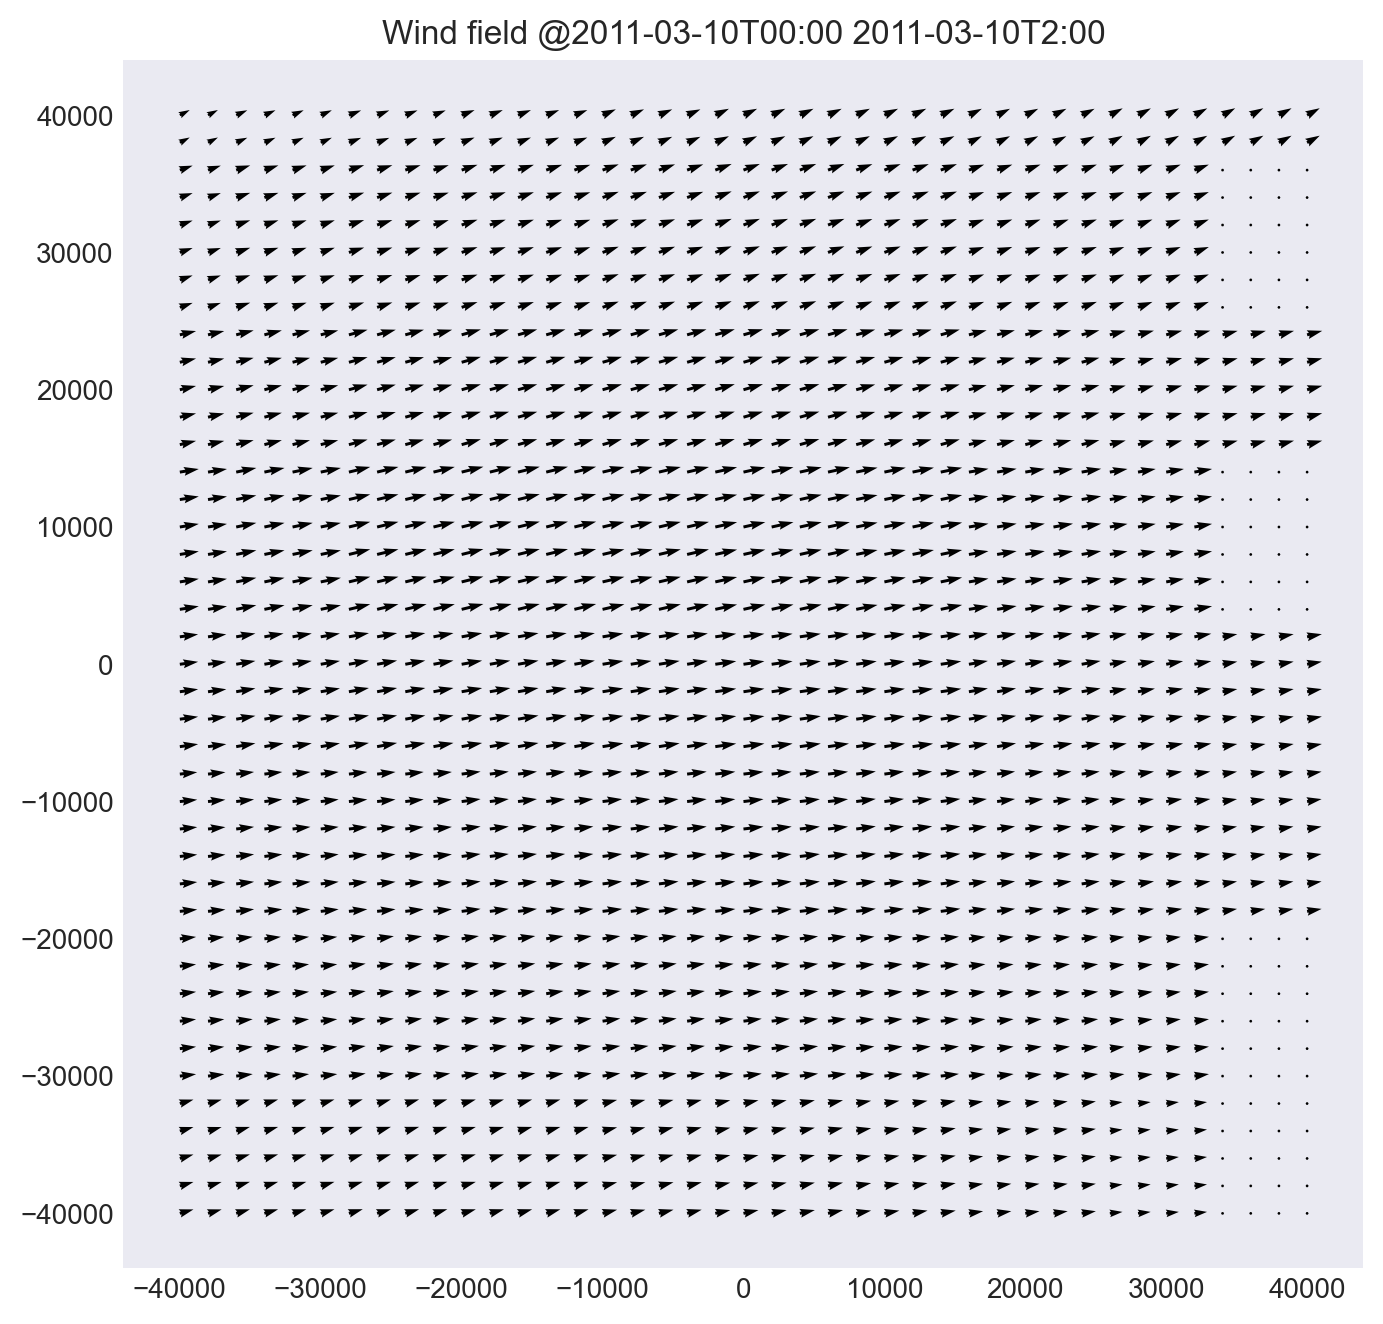

Running Gaussian Dispersion:   0%|                                           | 0/24 [00:00<?, ?it/s]

Done.
Not Sufficient Stabillity Data! Proceeding with PGF Class C
Plume Centerline Slope: 1.0


Running Gaussian Dispersion:  67%|██████████████████████▋           | 16/24 [00:06<00:02,  2.70it/s]/var/folders/1x/9gq9sq1d6nz7tp9snd05_ywh7n5yx7/T/ipykernel_96330/3281864945.py:288: RuntimeWarning:

invalid value encountered in arccos

Reshaping: 100%|████████████████████████████████████████████████| 1601/1601 [03:14<00:00,  8.23it/s]


Plotting...
run1


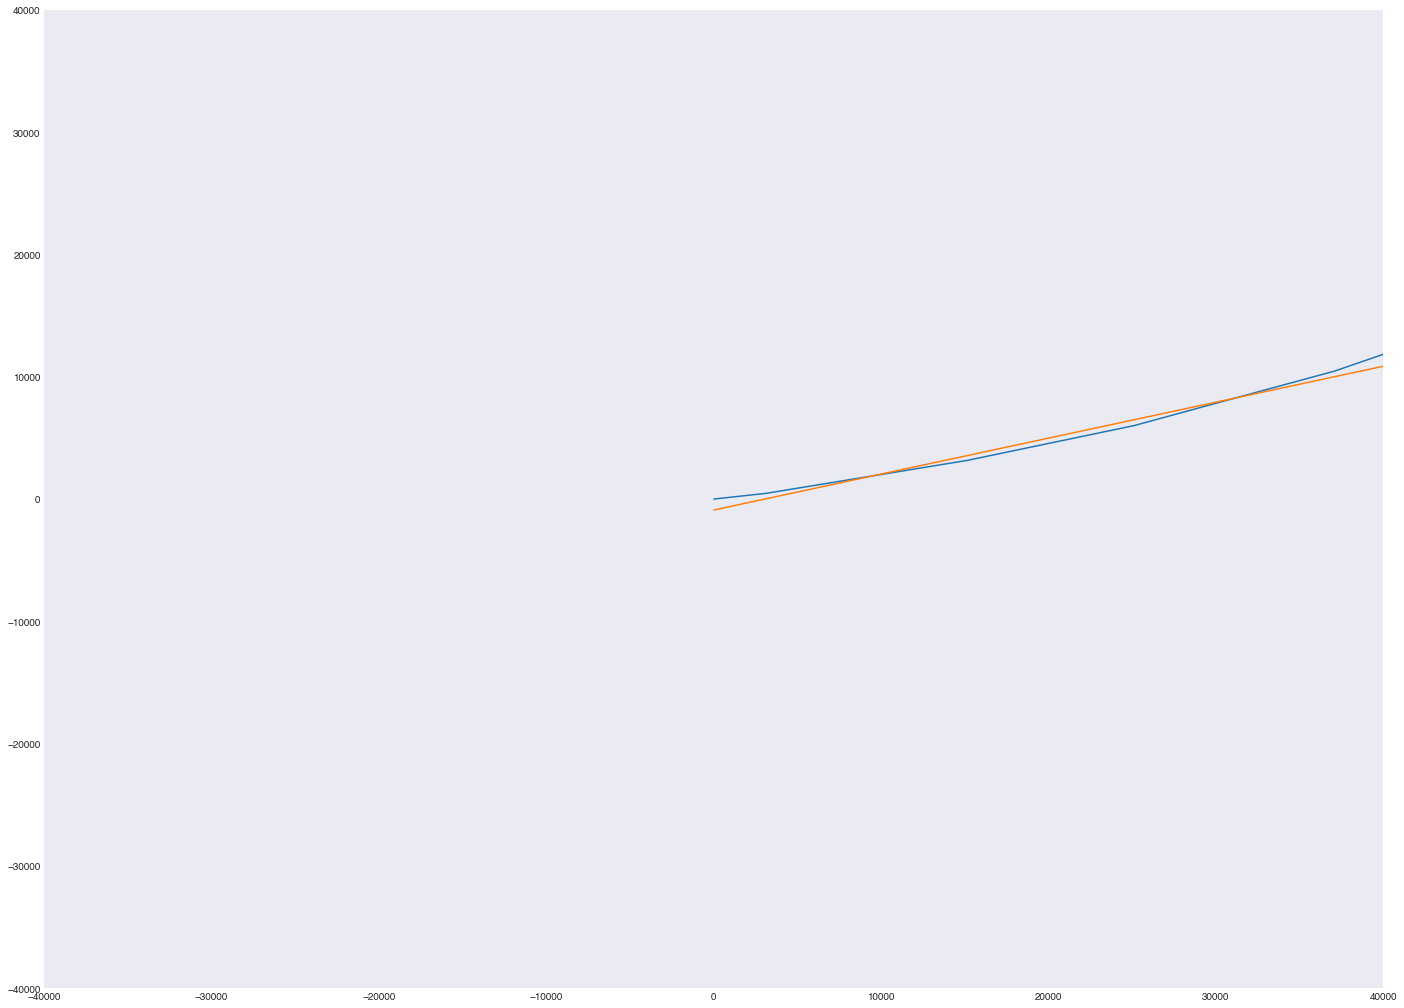

<Figure size 1728x1296 with 0 Axes>

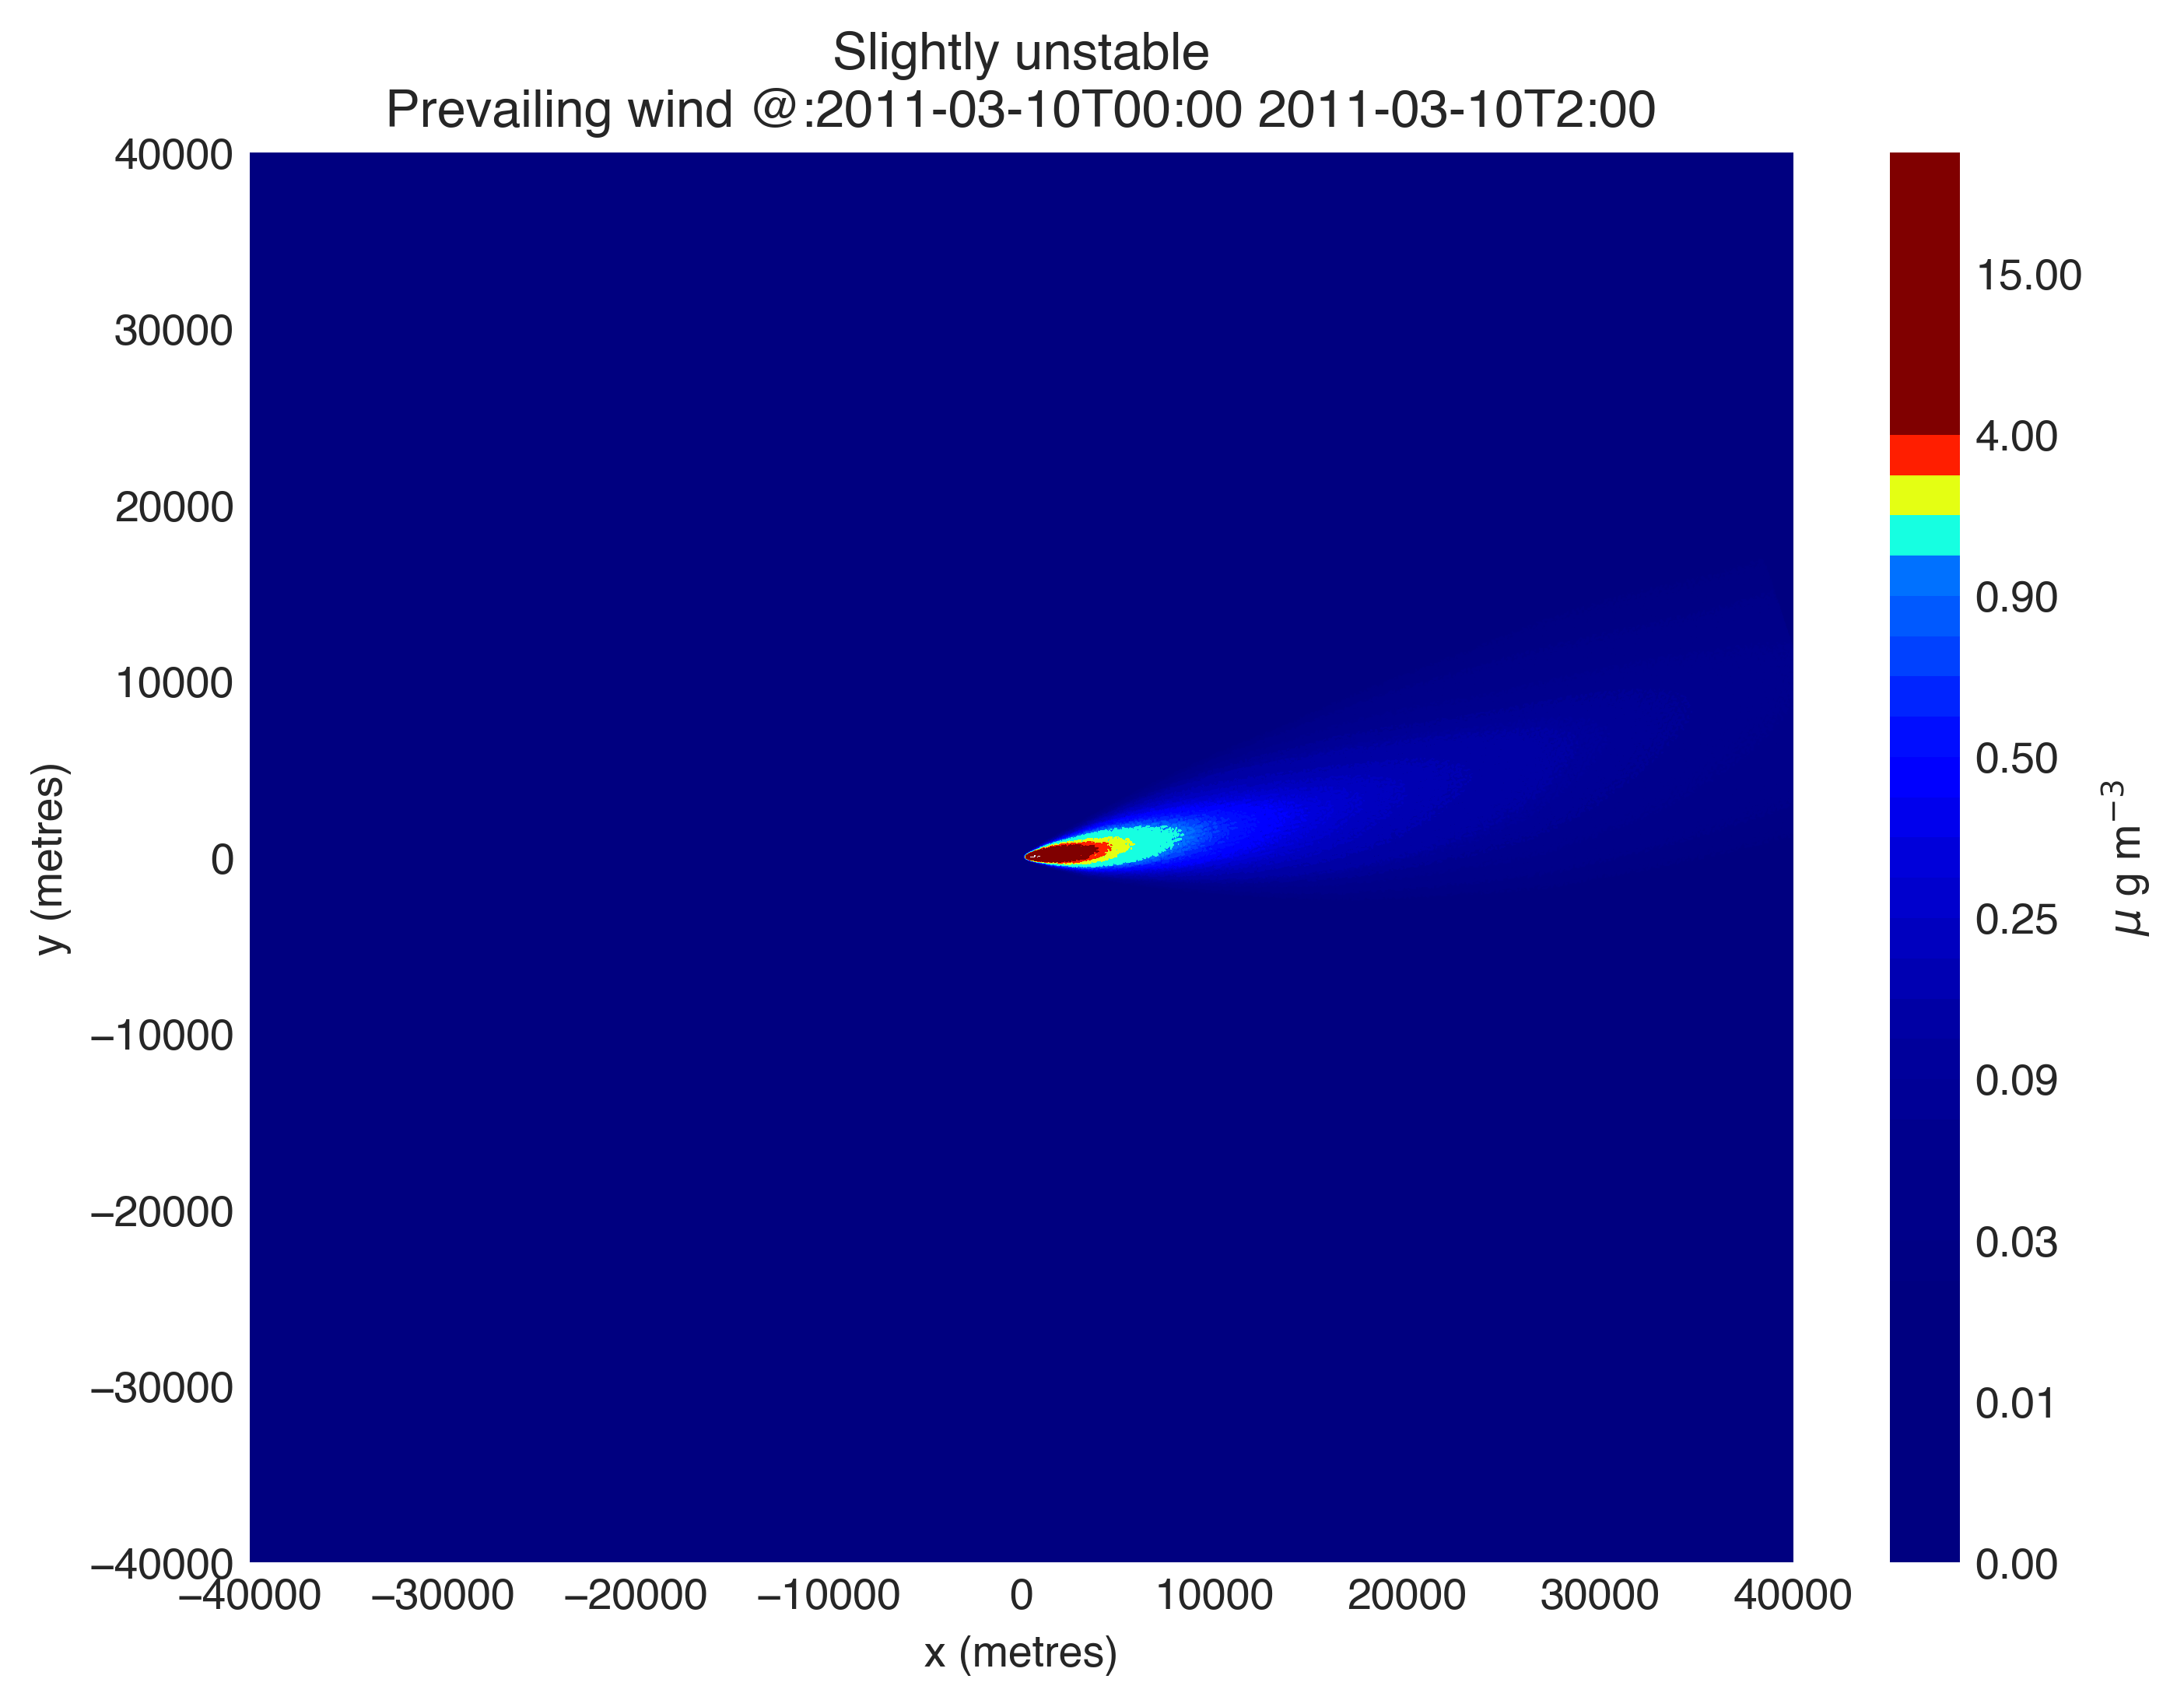

run2
[0]


IndexError: list index out of range

In [66]:
import ast
import json
import plotly.graph_objs as go
with open('fukumisc.txt') as f:
    content = f.readlines()
time = ['00:00',"2:00"] #Times to Run Model (use python RT datetime)
days = ['10'] #Date
for i in range(1,1682):
    extracted.append(ast.literal_eval(content[i]))
    
#print(extracted)
Cfin = []
for d in days:
    for t in range(len(time)):

        #print(f'2011-03-{d}T{time[t]}'+ ' ' + f'2011-03-{d}T{time[t+1]}')
        index = [x for x in range(len(content)) if f'2011-03-11T00:00:00 2011-03-11T03:00:00' in content[x]]
        print(index)
        extracted = []
        for i in range(index[0]+1,index[0]+1682):
            extracted.append(ast.literal_eval(content[i]))
        #print(extracted)
        apd = model(extracted,f'2011-03-{d}T{time[t]}'+ ' ' + f'2011-03-{d}T{time[t+1]}')
        Cfin.append(apd)

In [42]:
#np.savetxt("modeloutput.txt", Cfin)
print(Cfin[0][0])
import plotly.graph_objs as go
newfin = np.mean(Cfin, axis = 0)

feature_x = np.arange(-40000, 40000, 50) 
feature_y = np.arange(-40000, 40000, 50) 
#np.savetxt("modeloutput.txt", newfin)
# Creating 2-D grid of features 
[X, Y] = np.meshgrid(feature_x, feature_y) 

fig = go.Figure(data =
     go.Heatmap(x = feature_x, y = feature_y, z = newfin,colorscale = 'Jet',zmin=0, zmax=4))
fig.update_layout(
margin=dict(t=200, r=200, b=200, l=200),
showlegend=False,
width=1000, height=1000,    
autosize=False)



IndexError: list index out of range

In [14]:
import numpy
numpy.savetxt("modeloutput.txt", newfin)
print('Save Done.')

Save Done.
[0. 0. 0. ... 0. 0. 0.]


## DISPERSION MODEL ##

In [65]:
def model(extracted,stri): #Takes in wind field + date string label (Add PG Weather Data Here)
    import math
    import pandas as pd
    from tqdm import tqdm
    import time
    import folium
    import numpy as np
    from time import sleep
    import metpy.calc
    import matplotlib.pyplot as plt
    from scipy.integrate import odeint
    from matplotlib.pyplot import figure
    import sys
    from scipy.special import erfcinv as erfcinv
    import scipy.interpolate
    from scipy.interpolate import make_interp_spline
    from scipy import signal
    from scipy.interpolate import interp2d
    import scipy as sp

    solar = 100
    radius = 1000.0 # m - the following code is an approximation that stays reasonably accurate for distances < 100km
    centerLat =  37.429019 #latitude of circle center, decimal degrees
    centerLon = 140.527985# Longitude of circle center, decimal degrees

    # parameters
    N = 3 # number of discrete sample points to be generated along the circle
    scale = 100
    # generate points
    lat, lon = centerLat, centerLon #center coordinate
    dist, coors = 2000, 20 #meters, num coordinates in each direction

    #Creating the offset grid
    mini, maxi = -dist*coors, dist*coors
    n_coord = coors*2+1
    axis = np.linspace(mini, maxi, n_coord)
    X, Y = np.meshgrid(axis, axis)


    #avation formulate for offsetting the latlong by offset matrices
    R = 6378137 #earth's radius
    dLat = X/R
    dLon = Y/(R*np.cos(np.pi*lat/180))
    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi

    #stack x and y latlongs and get (lat,long) format
    output = np.stack([latO, lonO]).transpose(1,2,0)

    circlePoints = []
    for i in output:
        for x in i:
            circlePoints.append({'lat':x[0],'lon':x[-1]})
    %matplotlib inline
    plt.style.use('seaborn-dark')
    vects = []
    coords  = []
    trace_vects = {}
    dist, coors = 2000, 20
    axis = np.linspace(mini, maxi, n_coord) 
    x,y = np.meshgrid(axis, axis)
    #x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
    #print(mini, maxi, n_coord) #-4000 4000 5
    ul = []
    vl = []
    for i in extracted:
        working = list(i.values())
        if working[0] == None:
            working[0] = 0
        if working[1] == None:
            working[1] = 0
        ul.append(working[0])
        vl.append(working[-1])

    u = ul
    v = vl
    figure(figsize=(8, 8), dpi=200)
    plt.quiver(y,x,u,v,units='xy')
    plt.title("Wind field @" + stri)
    plt.show()
    #Data for Particle Array
    def windvector():
        windvectors = []
        for i in extracted:
            working = list(i.values())
            if working[0] == None:
                working[0] = 0.0001
                working[1] = 0.0001
            #OR PASS WINDVECT AS NONE
            w_vel = abs(math.sqrt(working[0]**2+working[-1]**2))
            w_angle = math.degrees(math.asin(working[-1]/w_vel))
            #patch for model
            if w_angle < 0:
                w_angle = abs(w_angle)
            if w_angle > 0:
                w_angle = -w_angle
            windvectors.append((w_vel,w_angle))
        return windvectors
    windvectors = windvector()
    for i in range(n_coord):
        for n in range(n_coord):
            coords.append((x[i,n],y[i,n]))
    for x in range(len(ul)):
        vects.append((ul[x],vl[x]))
    for f in range(len(extracted)):
        trace_vects.update({coords[f]:vects[f]})
    def closest_node(node, nodes):
        '''Finds the closest vectorized coordinates, returns index from given list'''
        nodes = np.asarray(nodes)
        dist_2 = np.sum((nodes - node)**2, axis=1)
        return np.argmin(dist_2)

    def vf_x(x,y):
        oper = closest_node((x,y), coords)
        find = coords[oper]
        return trace_vects[find][0]
    def vf_y(x,y):
        oper1 = closest_node((x,y), coords)
        find1 = coords[oper1]
        return trace_vects[find1][-1]

    x_lim = (-40000, 40000)
    y_lim = (-40000, 40000)
    step = 10
    partvel = []
    dist = []
    def particle_path(starting_point, step, vf_x, vf_y, x_lim, y_lim):
        for p in tqdm(range(1), ncols = 100, desc = 'Generating Particle Path'):
            func_x = []
            func_y = []
            # Find the points to the "right" of the point
            x = starting_point[0]
            y = starting_point[1]
            while True:
                func_x.append(x)
                func_y.append(y)

                delta_x = vf_x(x, y)
                delta_y = vf_y(x, y)

                # Normalize to unit vector and scale by 1/step
                magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2)
                delta_x = delta_x / magnitude * step
                delta_y = delta_y / magnitude * step
                partvel.append(magnitude)

                # Get the new point
                x = x + delta_x
                y = y + delta_y
                # Break if either x or y is outside of bounds
                if x > x_lim[1] or x < x_lim[0] or y > y_lim[1] or y < y_lim[0]:
                    break

                # Break if it's taking too long for the curve to leave the bounds
                if len(func_x) > 10000:
                    break

            # Find the points to the "left" of the point- nearly identical 
            x = starting_point[0]
            y = starting_point[1]
            while True:
                func_x.insert(0, x)
                func_y.insert(0, y)

                delta_x = vf_x(x, y)
                delta_y = vf_y(x, y)

                magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2)
                delta_x = delta_x / magnitude * step
                delta_y = delta_y / magnitude * step
                partvel.insert(0,magnitude)

                # Here, we subtract delta instead of add to find the second half
                x = x - delta_x
                y = y - delta_y

                if x > 5 or x < -5 or y > 5 or y < -5:
                    break
                if len(func_x) > 20000:
                    break 
        return func_x, func_y, dist

    func_x1, func_y1,dist = particle_path((0,0), step, vf_x, vf_y, x_lim, y_lim) #Generate path from center of area of interest
    coefficients = np.polyfit(func_x1, func_y1, 1)
    poly = np.poly1d(coefficients)
    new_x = np.linspace(func_x1[0], func_x1[-1])
    new_y = poly(new_x)
    plt.rcParams["figure.figsize"] = (24,18)
    fig, ax = plt.subplots()
    ax.plot(func_x1, func_y1)
    ax.plot(new_x, new_y) #Set regression again, only for the mapper function
    #ctr_x,ctr_y = ctrline(0,0)
    #ax.plot(ctr_x,ctr_y, 'g')
    ax.set_xlim(-40000, 40000)
    ax.set_ylim(-40000, 40000)
    tracker = {}
    timescale = [0]
    timecnt = 0
    partdist = []
    pd = 0

    for i in range(len(func_x1)-1): #Find Particle Distance w/steps
        x1,y1 = func_x1[i],func_y1[i]
        x2,y2 = func_x1[i+1],func_y1[i+1]
        pd = pd + math.hypot(x2 - x1, y2 - y1)
        partdist.append(round(pd))
    # t = dist/magnitude, and the sum the list of t time
    for i in range(len(partdist)-1):
        timecnt = timecnt + (partdist[i+1]-partdist[i])/partvel[i]
        timescale.append(timecnt)
    print('Done.')
    #INDEX: Returns func_x1 func_y1 (x,y particle path), partvel = vel. at coord, time = time s elapsed at coord, dist = dist m from org. at coord
    import tqdm
    def mapper(x,y,reshC):
        mapped = {}
        '''Maps coordinates to deposited amount, takes in x,y 2d arr. and C1 dep. amt. 2d array'''
        s1,s2 = reshC.shape[0],reshC.shape[-1] #finds array shape
        newC1 = np.zeros((s1,s2), dtype=float) #makes duplicate, but filled w/ float 0s
        for i in tqdm.tqdm(range(s2),ncols = 100,desc = 'Generating reference'):
            for z in range(s2):
                mapped.update({(x[i][z],y[i][z]):(i,z)}) #makes reference map
                    #print(x[i][z],y[i][z])
        for i in tqdm.tqdm(range(s2),ncols = 100,desc = 'Reshaping'):
            for z in range(s2):
                if reshC[i][z] != 0:
                    #print(x[i][z],y[i][z])
                    try:
                        reshapeout = reshaper(x[i][z],y[i][z]) #RESHAPE OK
                    #print(reshapeout)
                        outx = 50 * round(reshapeout[0]/50)
                        outy = 50 * round(reshapeout[-1]/50)
                        add = mapped[(outx,outy)]
                        newC1[add[0]][add[1]] = reshC[i][z]
                        if reshC[i][z] == 0:
                            print([add[0]][add[1]])
                    except:
                        #fill in with ones
                        #print coords to find issue
                        # maybe its centerline not past 0,0 need neg, or higher than 40000
                        # pattern is random
                        # Match the coor

                        pass

                    #

                    #print(C1[i][z],x[i][z],y[i][z])

                #pass var. coords at C1 i,z to reshape fx
                #writes same var at new loc newx,newy on newC1
        return newC1

    def reshaper(itx,ity):
        distancep,x2,y2 = point_to_line_dist([itx,ity], np.array([[ctr_x[0],ctr_y[0]],[ctr_x[-1],ctr_y[-1]]]))
        #init centrline for normal plume, returns shortestdist of point to ctrline as well as pt. of intersection 
        if y2 > ity: #inverse the distance if the point falls below centerline
            distancep = -distancep
        initdist = math.hypot(x2 - 0, y2 - 0) #distance of intersection from origin 0,0
        finded = math.ceil(initdist / 10) * 10 #round up to match distance with modded distance list
        idx = partdist.index(finded) #finds index of distance, to index boundary coordinates (as to get localized slope)
        m = np.poly1d.deriv(poly)#derivative of the polynomial
        m = m(func_x1[idx]) #Slope at indexed point
        diff = finded-initdist #finds difference from rounded number: to work backwards and get accurate distance
        x2a,y2a = func_x1[idx+1],func_y1[idx+1] #bound coords 2
        r = np.sqrt(1+m**2)
        xf,yf = x2a+(diff/r),y2a+(diff*m/r) #move back to cancel round indexing method
        invslope = -(1/m) #finds perpendicular slope
        r2 = np.sqrt(1+invslope**2)
        xf2,yf2 = xf+(distancep/r2),yf+(distancep*invslope/r2) #move along new slope to final particle position
        return float(xf2),float(yf2)
    #from calc_sigmas import calc_sigmas 
    # Gaussian Func Takes in var.
    def gauss_func(Q,u,dir1,x,y,z,xs,ys,H,Dy,Dz,STABILITY):
        u1=u;
        x1=x-xs; # shift the coordinates so that stack is centre point
        y1=y-ys; 

        # components of u in x and y directions
        wx=u1*np.sin((dir1-180.)*np.pi/180.);
        wy=u1*np.cos((dir1-180.)*np.pi/180.);

        # Need angle between point x, y and the wind direction, so use scalar product:
        dot_product=wx*x1+wy*y1;
       # product of magnitude of vectors:
        magnitudes=u1*np.sqrt(x1**2.+y1**2.); 

       # angle between wind and point (x,y)
        subtended=np.arccos(dot_product/(magnitudes+1e-15));
       # distance to point x,y from stack
        hypotenuse=np.sqrt(x1**2.+y1**2.);

       # distance along the wind direction to perpendilcular line that intesects
       # x,y
        downwind=np.cos(subtended)*hypotenuse;

       # Now calculate distance cross wind.
        crosswind=np.sin(subtended)*hypotenuse;

        ind=np.where(downwind>0.);
        C=np.zeros((len(x),len(y)));

       # sig_y=sqrt(2.*Dy.*downwind./u1);
       # sig_z=sqrt(2.*Dz.*downwind./u1);

       # calculate sigmas based on stability and distance downwind
        (sig_y,sig_z)=calc_sigmas(STABILITY,downwind);


        C[ind]=Q/(2.*np.pi*u1*sig_y[ind]*sig_z[ind]) \
            * np.exp(-crosswind[ind]**2./(2.*sig_y[ind]**2.))  \
            *(np.exp(-(z[ind]-H)**2./(2.*sig_z[ind]**2.)) + \
            np.exp(-(z[ind]+H)**2./(2.*sig_z[ind]**2.)) );
        return C

    def calc_sigmas(CATEGORY,x1):

        x=np.abs(x1)

        a=np.zeros(np.shape(x));
        b=np.zeros(np.shape(x));
        c=np.zeros(np.shape(x));
        d=np.zeros(np.shape(x));

        if CATEGORY == 1: # very unstable
            # vertical
            ind=np.where((x<100.) & (x>0.));
            a[ind]=122.800;b[ind]=0.94470;

            ind=np.where((x>=100.) & (x<150.));
            a[ind]=158.080;b[ind]=1.05420;

            ind=np.where((x>=150.) & (x<200.));
            a[ind]=170.220;b[ind]=1.09320;

            ind=np.where((x>=200.) & (x<250.));
            a[ind]=179.520;b[ind]=1.12620;

            ind=np.where((x>=250.) & (x<300.));
            a[ind]=217.410;b[ind]=1.26440;

            ind=np.where((x>=300.) & (x<400.));
            a[ind]=258.89;b[ind]=1.40940;

            ind=np.where((x>=400.) & (x<500.));
            a[ind]=346.75;b[ind]=1.7283;

            ind=np.where((x>=500.) & (x<3110.));
            a[ind]=453.85;b[ind]=2.1166;

            ind=np.where((x>=3110.));
            a[ind]=453.85;b[ind]=2.1166;

            # cross wind
            c[:]=24.1670;
            d[:]=2.5334;
        elif CATEGORY == 2: # moderately unstable
            # vertical
            ind=np.where((x<200.) & (x>0.));
            a[ind]=90.673;b[ind]=0.93198;

            ind=np.where((x>=200.) & (x<400.));
            a[ind]=98.483;b[ind]=0.98332;

            ind=np.where(x>=400.);
            a[ind]=109.3;b[ind]=1.09710;

            # cross wind
            c[:]=18.3330;
            d[:]=1.8096;

        elif CATEGORY == 3: # slightly unstable
            # vertical
            a[:]=61.141;
            b[:]=0.91465;
            # cross wind
            c[:]=12.5;
            d[:]=1.0857;
        elif CATEGORY == 4: # neutral
            # vertical
            ind=np.where((x<300.) &(x>0.));
            a[ind]=34.459;b[ind]=0.86974;

            ind=np.where((x>=300.) & (x<1000.));
            a[ind]=32.093;b[ind]=0.81066;

            ind=np.where((x>=1000.) & (x<3000.));
            a[ind]=32.093;b[ind]=0.64403;

            ind=np.where((x>=3000.) & (x<10000.));
            a[ind]=33.504;b[ind]=0.60486;

            ind=np.where((x>=10000.) & (x<30000.));
            a[ind]=36.650;b[ind]=0.56589;

            ind=np.where(x>=30000.);
            a[ind]=44.053;b[ind]=0.51179;

            # cross wind
            c[:]=8.3330;
            d[:]=0.72382;
        elif CATEGORY == 5: # moderately stable
            # vertical
            ind=np.where((x<100.) & (x>0.));
            a[ind]=24.26;b[ind]=0.83660;

            ind=np.where((x>=100.) & (x<300.));
            a[ind]=23.331;b[ind]=0.81956;

            ind=np.where((x>=300.) & (x<1000.));
            a[ind]=21.628;b[ind]=0.75660;

            ind=np.where((x>=1000.) & (x<2000.));
            a[ind]=21.628;b[ind]=0.63077;

            ind=np.where((x>=2000.) & (x<4000.));
            a[ind]=22.534;b[ind]=0.57154;

            ind=np.where((x>=4000.) & (x<10000.));
            a[ind]=24.703;b[ind]=0.50527;

            ind=np.where((x>=10000.) & (x<20000.));
            a[ind]=26.970;b[ind]=0.46713;

            ind=np.where((x>=20000.) & (x<40000.));
            a[ind]=35.420;b[ind]=0.37615;

            ind=np.where(x>=40000.);
            a[ind]=47.618;b[ind]=0.29592;

            # cross wind
            c[:]=6.25;
            d[:]=0.54287;
        elif CATEGORY == 6: # very stable
            # vertical
            ind=np.where((x<200.) & (x>0.));
            a[ind]=15.209;b[ind]=0.81558;

            ind=np.where((x>=200.) & (x<700.));
            a[ind]=14.457;b[ind]=0.78407;

            ind=np.where((x>=700.) & (x<1000.));
            a[ind]=13.953;b[ind]=0.68465;

            ind=np.where((x>=1000.) & (x<2000.));
            a[ind]=13.953;b[ind]=0.63227;

            ind=np.where((x>=2000.) & (x<3000.));
            a[ind]=14.823;b[ind]=0.54503;

            ind=np.where((x>=3000.) & (x<7000.));
            a[ind]=16.187;b[ind]=0.46490;

            ind=np.where((x>=7000.) & (x<15000.));
            a[ind]=17.836;b[ind]=0.41507;

            ind=np.where((x>=15000.) & (x<30000.));
            a[ind]=22.651;b[ind]=0.32681;

            ind=np.where((x>=30000.) & (x<60000.));
            a[ind]=27.074;b[ind]=0.27436;

            ind=np.where(x>=60000.);
            a[ind]=34.219;b[ind]=0.21716;

            # cross wind
            c[:]=4.1667;
            d[:]=0.36191;
        else:
            sys.exit()

        sig_z=a*(x/1000.)**b;
        sig_z[np.where(sig_z[:]>5000.)]=5000.;

        theta=0.017453293*(c-d*np.log(np.abs(x+1e-15)/1000.));
        sig_y=465.11628*x/1000.*np.tan(theta);

        return (sig_y,sig_z)

    #HELPER Functions for Plume Reshaping-----------------------------------
    def point_to_line_dist(point, line):
        """Calculate the distance between a point and a line segment.

        To calculate the closest distance to a line segment, we first need to check
        if the point projects onto the line segment.  If it does, then we calculate
        the orthogonal distance from the point to the line.
        If the point does not project to the line segment, we calculate the 
        distance to both endpoints and take the shortest distance.

        :param point: Numpy array of form [x,y], describing the point.
        :type point: numpy.core.multiarray.ndarray
        :param line: list of endpoint arrays of form [P1, P2]
        :type line: list of numpy.core.multiarray.ndarray
        :return: The minimum distance to a point.
        :rtype: float
        """
        # unit vector
        unit_line = line[1] - line[0]
        norm_unit_line = unit_line / np.linalg.norm(unit_line)

        # compute the perpendicular distance to the theoretical infinite line
        segment_dist = (
            np.linalg.norm(np.cross(line[1] - line[0], line[0] - point)) /
            np.linalg.norm(unit_line)
        )

        diff = (
            (norm_unit_line[0] * (point[0] - line[0][0])) + 
            (norm_unit_line[1] * (point[1] - line[0][1]))
        )

        x_seg = (norm_unit_line[0] * diff) + line[0][0]
        y_seg = (norm_unit_line[1] * diff) + line[0][1]

        endpoint_dist = min(
            np.linalg.norm(line[0] - point),
            np.linalg.norm(line[1] - point)
        )

        # decide if the intersection point falls on the line segment
        lp1_x = line[0][0]  # line point 1 x
        lp1_y = line[0][1]  # line point 1 y
        lp2_x = line[1][0]  # line point 2 x
        lp2_y = line[1][1]  # line point 2 y
        is_betw_x = lp1_x <= x_seg <= lp2_x or lp2_x <= x_seg <= lp1_x
        is_betw_y = lp1_y <= y_seg <= lp2_y or lp2_y <= y_seg <= lp1_y
        if is_betw_x and is_betw_y:
            return segment_dist,x_seg,y_seg #Returns DIST and X,Y on line
        else:
            # if not, then return the minimum distance to the segment endpoints
            return endpoint_dist

    #from gauss_func import gauss_func

    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    ## for Palatino and other serif fonts use:
    #rc('font',**{'family':'serif','serif':['Palatino']})
    rc('text', usetex=False)

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    def sourcestack(initval, rate, timescale):
        sourcestackl = []
        sourcestackl.append(initval)
        for i in range(len(timescale)):
            sourcestackl.append(rate*timescale[i])
        return sourcestackl
        '''Takes in intitial release value, as well as rate of release in mass emitted (g) per unit time (s), 
        returns timescale of release in terms of total amount in modelling system'''


    def ctrline(x,y,slope):
        ctr_x = [x]
        ctr_y = [y]
        step = 10
        slope = 1.0
        print(f'Plume Centerline Slope:', slope)
        if slope > 0:
            xc = 0
            while ctr_y[-1] < 40000 and ctr_x[-1] < 40000:
                xc = xc+step
                ctr_x.append(xc)
                ctr_y.append(xc*slope)
        if windvectors[20][-1] < 0:
            xc = 0
            if ctr_x[-1] > -40000 and ctr_y[-1] > -40000:
                xc = xc-step
                ctr_x.append(x)
                ctr_y.append(xc*slope)
        return ctr_x[:-1],ctr_y[:-1]



    ###########################################################################
    # Do not change these variables                                           #
    ###########################################################################


    # SECTION 0: Definitions (normally don't modify this section)
    # view
    PLAN_VIEW=1;
    HEIGHT_SLICE=2;
    SURFACE_TIME=3;
    NO_PLOT=4;

    # wind field
    CONSTANT_WIND=1;
    FLUCTUATING_WIND=2;
    PREVAILING_WIND=3;

    # number of stacks
    ONE_STACK=1;
    TWO_STACKS=2;
    THREE_STACKS=3;

    # stability of the atmosphere
    CONSTANT_STABILITY=1;
    ANNUAL_CYCLE=2;
    stability_str=['Very unstable','Moderately unstable','Slightly unstable', \
        'Neutral','Moderately stable','Very stable'];
    # Aerosol properties
    HUMIDIFY=2;
    DRY_AEROSOL=1;

    I131=1;
    CS134=2;
    CS137=3;
    AMMONIUM_NITRATE=4;
    #ONLY USED IN HUMIDIFYING CONDITIONS
    nu=[2., 2.5, 1., 2.];
    rho_s=[2160., 1840., 1873., 1725.]; #Densities kg*m-3
    Ms=[58.44e-3, 98e-3, 132e-3, 80e-3]; #Molar Mass in kg/mol
    Mw=18e-3; #Molecular Weight


    dxy=50;          # resolution of the model in both x and y directions
    dz=5;
    x=np.mgrid[-40000:40000+dxy:dxy]; # solve on a 40 km domain
    #x=np.mgrid[-4000:4000+dxy:dxy]; # solve on a 4 km domain (TESTING)
    y=x;              # x-grid is same as y-grid
    ###########################################################################

    # SECTION 1: Configuration
    # Variables can be changed by the user+++++++++++++++++++++++++++++++++++++
    #RH=0.70; #Default Relative Humidity
    aerosol_type=CS137;

    dry_size=60e-9; #Aerosol Diameter (m)
    humidify=HUMIDIFY;

    if solar == None:
        stab1 = 3;
        print('Not Sufficient Stabillity Data! Proceeding with PGF Class C')
    #Find PG Stabillity from Wind Speed, # set from 1-6, but we only use 5 for cases, A-E
    if windvectors[20][0] <= 2 and solar > 600:
        stab1=1;
        print('Proceeding with PGF Class A')
    if windvectors[20][0] <= 2 and 250 < solar < 450:
        stab1=2;
        print('Proceeding with PGF Class B')
    if 2 < windvectors[20][0] <= 3 and 450 < solar < 600:
        stab1=2;
        print('Proceeding with PGF Class B')
    if 2 < windvectors[20][0] <= 3 and 250 < solar < 450:
        stab1=2;
        print('Proceeding with PGF Class B')
    if 3 < windvectors[20][0] <= 5 and 250 < solar < 450:
        stab1=3;
        print('Proceeding with PGF Class C')
    if 5 < windvectors[20][0] <= 6 and 150 < solar < 250:
        stab1=4;
        print('Proceeding with PGF Class D')
    if 5 < windvectors[20][0] <= 6 and 250 < solar < 450:
        stab1=4;
        print('Proceeding with PGF Class D')
    if 5 < windvectors[20][0] <= 6 and 450 < solar < 600:
        stab1=3;
        print('Proceeding with PGF Class C')
    if 6 < windvectors[20][0] and solar <= 150:
        stab1=5;
        print('Proceeding with PGF Class E')
    else:
        stab1 = 3
        print('Not Sufficient Stabillity Data! Proceeding with PGF Class C')
    stability_used=CONSTANT_STABILITY;
    ##Determine Start windspeed
    ws = windvectors[840][0]##windspeed (m/s) - Input into model at point 0,0
    output=PLAN_VIEW;
    x_slice=39; # position (1-50) to take the slice in the x-direction
    y_slice=39;  # position (1-50) to plot concentrations vs time

    #---------Source Integration Scheme------------ (Polaris and PolarisCOMET)
    sourcexvalues = np.array(range(-200, 200, 100))
    sourceyvalues = np.array(range(-200, 200, 100))
    srcxx, srcyy = np.meshgrid(sourcexvalues, sourceyvalues)

    wind= PREVAILING_WIND
    stacks= 1 #len(srcxx.flatten())
    stack_x=srcxx.flatten();
    stack_y=srcyy.flatten();
    stack_x=[0]
    stack_y=[0]

    Q=[6.8, 5., 10.]; # mass emitted per unit time (g/s)
    Q = [6.8 for i in range(stacks)]
    H=[50 for i in range(stacks)]; # stack height, m
    hours=24;          # run the model for x hours (default: 3 for ECMWF GFS)
    #--------------------------------------------------------------------------
    times=np.mgrid[1:(hours)*1+1:1]/24.;

    Dy=10.;
    Dz=10.;

    # SECTION 2: Act on the configuration information

    # Decide which stability profile to ue
    if stability_used == CONSTANT_STABILITY:
        stability=stab1*np.ones((hours*1,1));
        stability_str=stability_str[stab1-1];
    elif stability_used == ANNUAL_CYCLE:
        stability=np.round(2.5*np.cos(times*2.*np.pi/(365.))+3.5);
        stability_str='Annual cycle';
    else:
        sys.exit()


    # decide what kind of run to do, plan view or y-z slice, or time series
    if output == PLAN_VIEW or output == SURFACE_TIME or output == NO_PLOT:

        C1=np.zeros((len(x),len(y),(hours)*1)); # array to store data, initialised to be zero

        [x,y]=np.meshgrid(x,y); # x and y defined at all positions on the grid
        z=np.zeros(np.shape(x));    # z is defined to be at ground level.
    elif output == HEIGHT_SLICE:
        z=np.mgrid[0:500+dz:dz];       # z-grid

        C1=np.zeros((len(y),len(z),(hours)*1)); # array to store data, initialised to be zero

        [y,z]=np.meshgrid(y,z); # y and z defined at all positions on the grid
        x=x[x_slice]*np.ones(np.shape(y));    # x is defined to be x at x_slice       
    else:
        sys.exit()

    # Set the wind based on input flags++++++++++++++++++++++++++++++++++++++++
    wind_speed=ws*np.ones(((hours)*1,1)); # m/s
    if wind == CONSTANT_WIND:
        wind_dir=270+windvectors[20][-1]*np.ones(((hours)*1,1)); #use generated vectors here
        wind_dir_str='Constant wind';
    elif wind == FLUCTUATING_WIND:
        wind_dir=360.*np.random.rand((hours)*1,1);
        wind_dir_str='Random wind';
    elif wind == PREVAILING_WIND:
        wind_dir=-np.sqrt(2.)*erfcinv(2.*np.random.rand((hours)*1,1))*7.; #norminv(rand(days.*24,1),0,40); - #Plume Spread Variation
       # note at this point you can add on the prevailing wind direction, i.e.
        wind_dir=wind_dir+270-45;
        ctr_x,ctr_y = ctrline(0,0,abs(windvectors[20][-1]))
        wind_dir[np.where(wind_dir>=360.)]= \
            np.mod(wind_dir[np.where(wind_dir>=360)],360);
        wind_dir_str='Prevailing wind';
    else:
        sys.exit()
    #--------------------------------------------------------------------------

    # SECTION 3: Main loop
    # For all times...
    C1=np.zeros((len(x),len(y),len(wind_dir)))
    for i in tqdm.tqdm(range(0,len(wind_dir)),ncols = 100, desc = 'Running Gaussian Dispersion'):
        for j in range(0,stacks):
            C=np.ones((len(x),len(y)))
            C=gauss_func(Q[j],wind_speed[i],wind_dir[i],x,y,z,
                stack_x[j],stack_y[j],H[j],Dy,Dz,stability[i]);
            C1[:,:,i]=C1[:,:,i]+C;


    #print(f'Reshaping Array Type', type(C1))
    # SECTION 4: Post process / output
    C2 = np.mean(C1,axis=2)*1e6
    C3 = mapper(x,y,C2)

    sigma_y = 0.5
    sigma_x = 0.5
    sigma = [sigma_y, sigma_x]
    C4 = sp.ndimage.filters.gaussian_filter(C3, sigma, mode='mirror') #denoise image

    # decide whether to humidify the aerosol and hence increase the mass
    if humidify == DRY_AEROSOL:
        print('[do not humidify] - Plotting, this may take several minutes...');
    elif humidify == HUMIDIFY:
        mass=np.pi/6.*rho_s[aerosol_type]*dry_size**3.;
        moles=mass/Ms[aerosol_type];

        nw=RH*nu[aerosol_type]*moles/(1.-RH);
        mass2=nw*Mw+moles*Ms[aerosol_type];
        C1=C1*mass2/mass; 
    else:
        sys.exit()

    # output the plots
    if output == PLAN_VIEW:
        print('Plotting...')
        print('run1')
        plt.figure()
        plt.ion()
        plt.figure(figsize=(8, 6), dpi=400)
        plt.contourf(x,y,C4, cmap='jet', levels=[0,0.0005,0.001, 0.003,0.005,0.008, 0.01, 0.02,0.03,0.04,0.05,0.07,0.09,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,10,15,20,30,40],); #mean of all day lists
        plt.clim((0, 4));
        plt.title(stability_str + '\n' + wind_dir_str + ' @:' + stri);
        plt.xlabel('x (metres)');
        plt.ylabel('y (metres)');
        cb1=plt.colorbar();
        cb1.set_label('$\mu$ g m$^{-3}$');
        #### import plotly.graph_objects as go
        #fig.show()
        plt.show()
        print('run2')
        return C4


    elif output == HEIGHT_SLICE:
        plt.figure();
        plt.ion()

        plt.pcolor(y,z,np.mean(C1,axis=1)*1e6, cmap='jet') 
        plt.clim((0,1e2));
        plt.xlabel('y (metres)');
        plt.ylabel('z (metres)');
        plt.title(stability_str + '\n' + wind_dir_str);
        cb1=plt.colorbar();
        cb1.set_label('$\mu$ g m$^{-3}$');
        plt.show()

    elif output == SURFACE_TIME:
        f,(ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        ax1.plot(times,1e6*np.squeeze(C4[y_slice,x_slice,:]));
        try:
            ax1.plot(times,smooth(1e6*np.squeeze(C4[y_slice,x_slice,:]),24),'r');
            ax1.legend(('Hourly mean','Daily mean'))
        except:
            sys.exit()

        ax1.set_xlabel('time (days)');
        ax1.set_ylabel('Mass loading ($\mu$ g m$^{-3}$)');
        ax1.set_title(stability_str +'\n' + wind_dir_str);

        ax2.plot(times,stability);
        ax2.set_xlabel('time (days)');
        ax2.set_ylabel('Stability parameter');
        f.show()

    elif output == NO_PLOT:
        print('don''t plot');
    else:
        sys.exit()

In [13]:
def ugtokbq(ug):
    conv1 = int(3.215*10**12)*(float(ug)*10**-6)#gets bq from ugrams
    return conv1/1000
ugtokbq(35)

112524.99999999999

In [ ]:
#UPDATE 15/03/22
#Model Updates : Localized WindSpeed, P.G Refresher, Weather Inputs Check (Fanning)
#Model Updates 2: USE ERA5 and optimize single-shot downloader vs. 8min from GEE (Use as loading and setup screen in website)
# - Here we still use the information from ERA5 and update hourly - MP model is out of project scope
#Model Updates 3: Uncertainty Analysis w/ Model Plotter + Code Mod to Polaris
#Polaris New Era - Finish up Fukushima with ERA5 then [SRTM90 Terrain Integration + RTMA]
#Particle Time Combine ie. Prediction of Polutant time to reach spot of measurement
#Polaris Website + Reporting Users

# visualize

In [ ]:
# UPDATE PUSH FOR FULL RELEASE W/RT METROLOGY
#Model Updates : Localized WindSpeed, P.G Refresher, Weather Inputs Check (Fanning)
#[SRTM90 Terrain Integration + ECMWF]
#Particle Time Combine ie. Prediction of Polutant time to reach spot of measurement
#Polaris Website + Reporting Users
#Release Tracking (Total Amt of Isotope in System)
# Release Binning with Real Time steps, so small releases can be coumputed in real time